In [1]:
from bs4 import BeautifulSoup
import re
import sys
import requests
import pandas as pd
from user_agent import generate_user_agent

In [2]:
username = input()

page_link =f'https://myanimelist.net/animelist/{username}?status=2'
headers = {'User-Agent': generate_user_agent(device_type="desktop", os=('mac', 'linux'))}

 xzeqtr


In [3]:
try:
    page_response = requests.get(page_link, timeout=5, headers=headers)
    if page_response.status_code == 200:
        page_content = BeautifulSoup(page_response.content, 'html.parser')
    else:
        print(page_response.status_code)
        sys.exit()
except requests.Timeout as e:
    print("It is time to timeout")
    print(str(e))

In [4]:
tables = page_content.find_all('table',{'class':'list-table'})
table_items = re.findall(r'data-items="(\[.*\])">', str(tables[0])\
                    .replace('\\&quot;', "'")\
                    .replace('&quot;', '"'))

df = pd.read_json(table_items[0])

finaldf = df.drop(['status', 'created_at', 'updated_at', 'tags', 'anime_id', 'is_rewatching', 'num_watched_episodes', \
                'anime_studios', 'anime_licensors', 'anime_season', 'anime_airing_status', \
                'has_episode_video', 'has_promotion_video', 'has_video', 'video_url', \
                'is_added_to_list', 'start_date_string', 'finish_date_string',\
                'anime_start_date_string', 'anime_end_date_string', 'days_string',\
                'storage_string', 'priority_string', 'notes', 'editable_notes', 'title_localized',\
                'anime_title_eng', 'anime_total_members', 'anime_total_scores',\
                'demographics'], axis=1)

In [5]:
finaldf.rename(columns={\
    "score":"User_score",\
    "anime_title":"Title",\
    "anime_num_episodes":"Episodes",\
    "anime_score_val":"Score",\
    "genres":"Genres",\
    "anime_url":"URL",\
    "anime_image_path":"Image",\
    "anime_media_type_string":"Type",\
    "anime_mpaa_rating_string":"Rating"}, inplace=True)

<AxesSubplot:title={'center':'Anime type'}, ylabel='Count'>

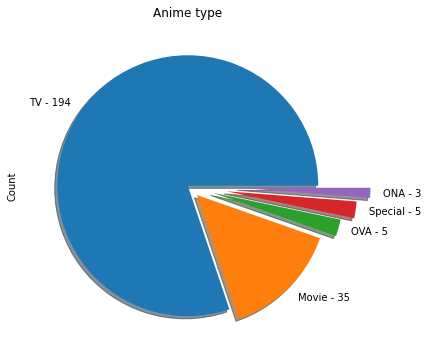

In [6]:
types = finaldf['Type'].value_counts().reset_index()
types.columns = ['Type', 'Count']
types_labels = [k+' - '+str(v) for k, v in zip(types['Type'], types['Count'])]
types.set_index('Type', inplace=True)

types.plot.pie(y = 'Count', \
            title = 'Anime type', \
            shadow = True, \
            explode = [_/10 for _ in range(len(types['Count']))], \
            legend = False, \
            figsize = (6, 6), \
            labels = types_labels)

<AxesSubplot:title={'center':'User score'}, ylabel='Count'>

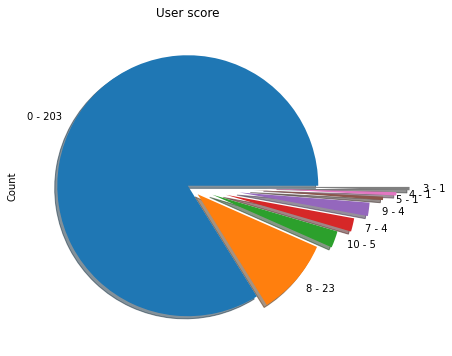

In [7]:
score = finaldf['User_score'].value_counts().reset_index()
score.columns = ['User_score', 'Count']
score.sort_values(by=['User_score'], ascending=False)

score_labels = [str(k)+' - '+str(v) for k, v in zip(score['User_score'], score['Count'])]
score.set_index('User_score', inplace=True)

score.plot.pie(y = 'Count', \
            title = 'User score', \
            shadow = True, \
            explode = [_/10 for _ in range(len(score['Count']))], \
            legend = False, \
            figsize = (6, 6), \
            labels = score_labels)